# Exploration of the Power Usage dataset from 2016 to 2020 Houston TX.

### Import libraries, dataset, and perform basic data review and adjustment

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox


In [34]:
df = pd.read_csv('power_usage_2016_to_2020.csv')

In [35]:
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [36]:
df.describe()

,Value (kWh),day_of_week
count,35952.000000,35952.000000
mean,0.891631,2.997330
std,0.908133,1.999024
min,0.064000,0.000000
25%,0.323750,1.000000
50%,0.501000,3.000000
75%,1.072000,5.000000
max,6.446000,6.000000


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [38]:
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['notes'] = df['notes'].astype(str)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   Value (kWh)  35952 non-null  float64       
 2   day_of_week  35952 non-null  int64         
 3   notes        35952 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [40]:
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [41]:
df.isna().sum()

StartDate      0
Value (kWh)    0
day_of_week    0
notes          0
dtype: int64

In [42]:
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


<Axes: xlabel='StartDate'>

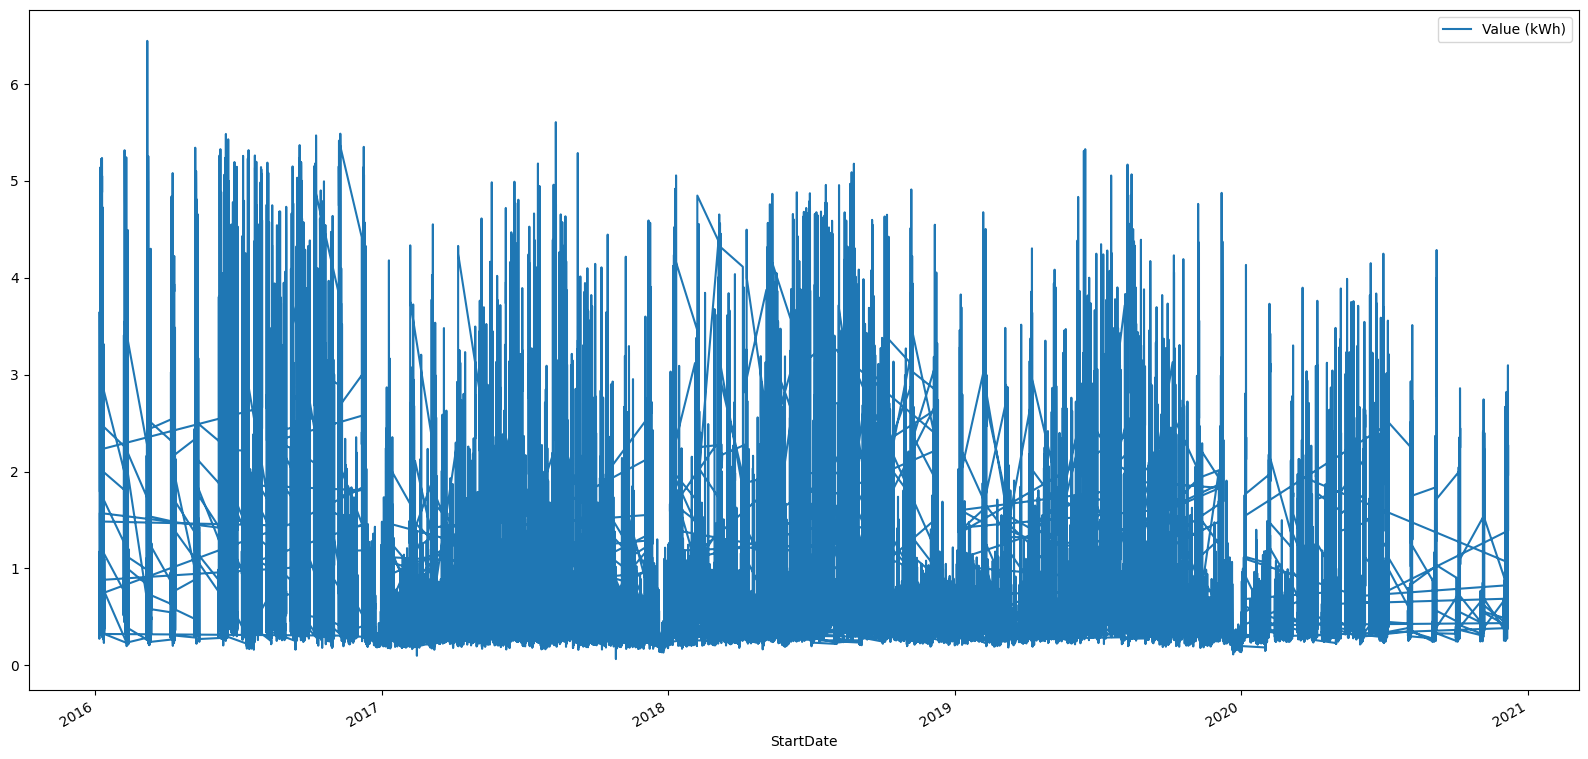

In [43]:
df.plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10))

### Data appears to have odd anomalies as seen by the drastic line changes. This could indicate corrupted data, missing data, or unordered data

In [44]:
sorteddf = df.sort_values(by='StartDate',ascending=True)

<Axes: xlabel='StartDate'>

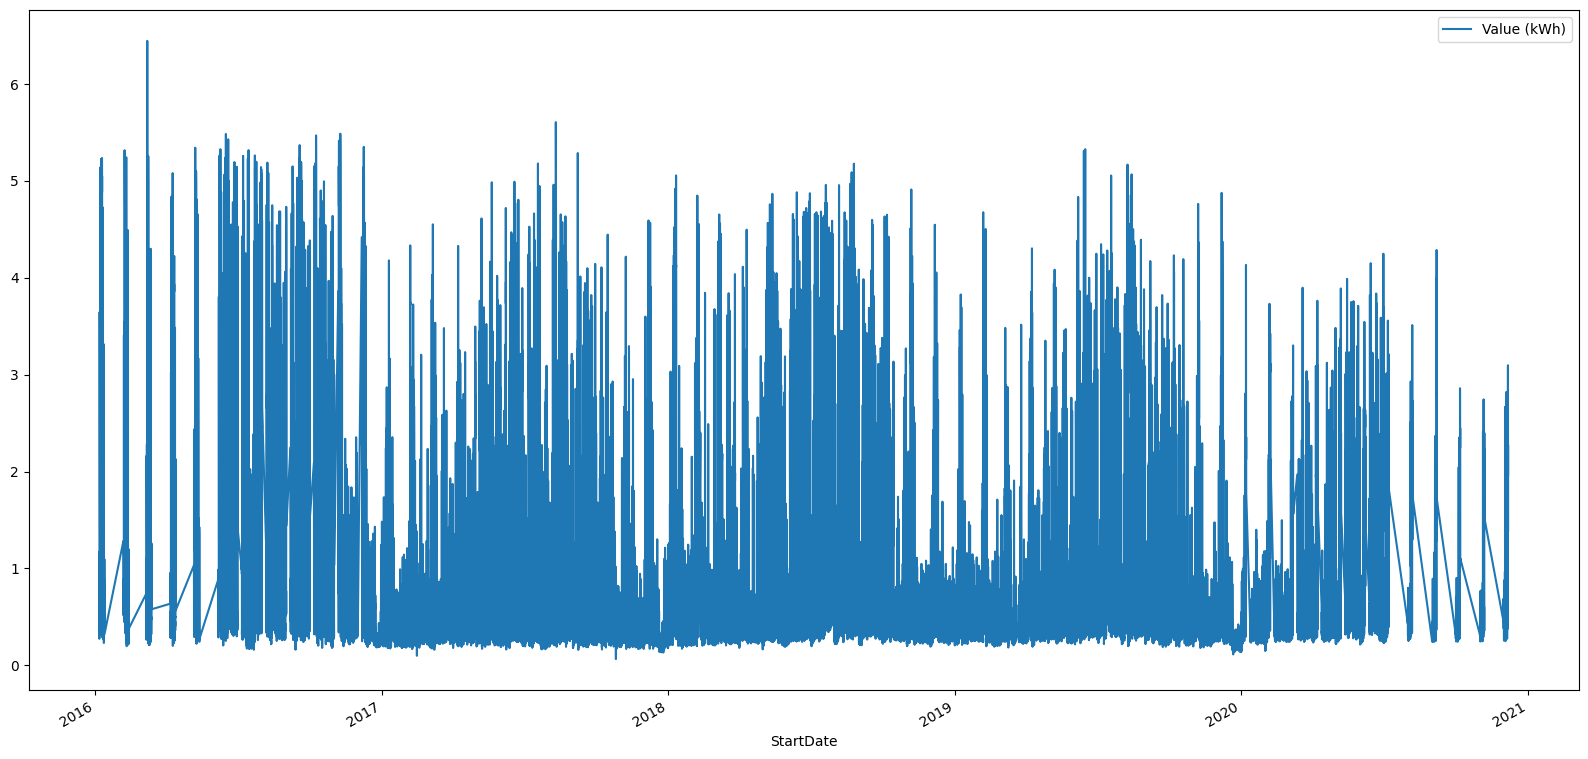

In [45]:
sorteddf.plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10))

### Basic sorting of the dates appeared to have help, but uncovered odd data in 2016 and 2020. Further review of the 2016 will be done in order to get a better understanding of the data.

In [46]:
sorteddf['year'] = sorteddf['StartDate'].dt.year
sorteddf['month'] = sorteddf['StartDate'].dt.month

<Axes: xlabel='StartDate'>

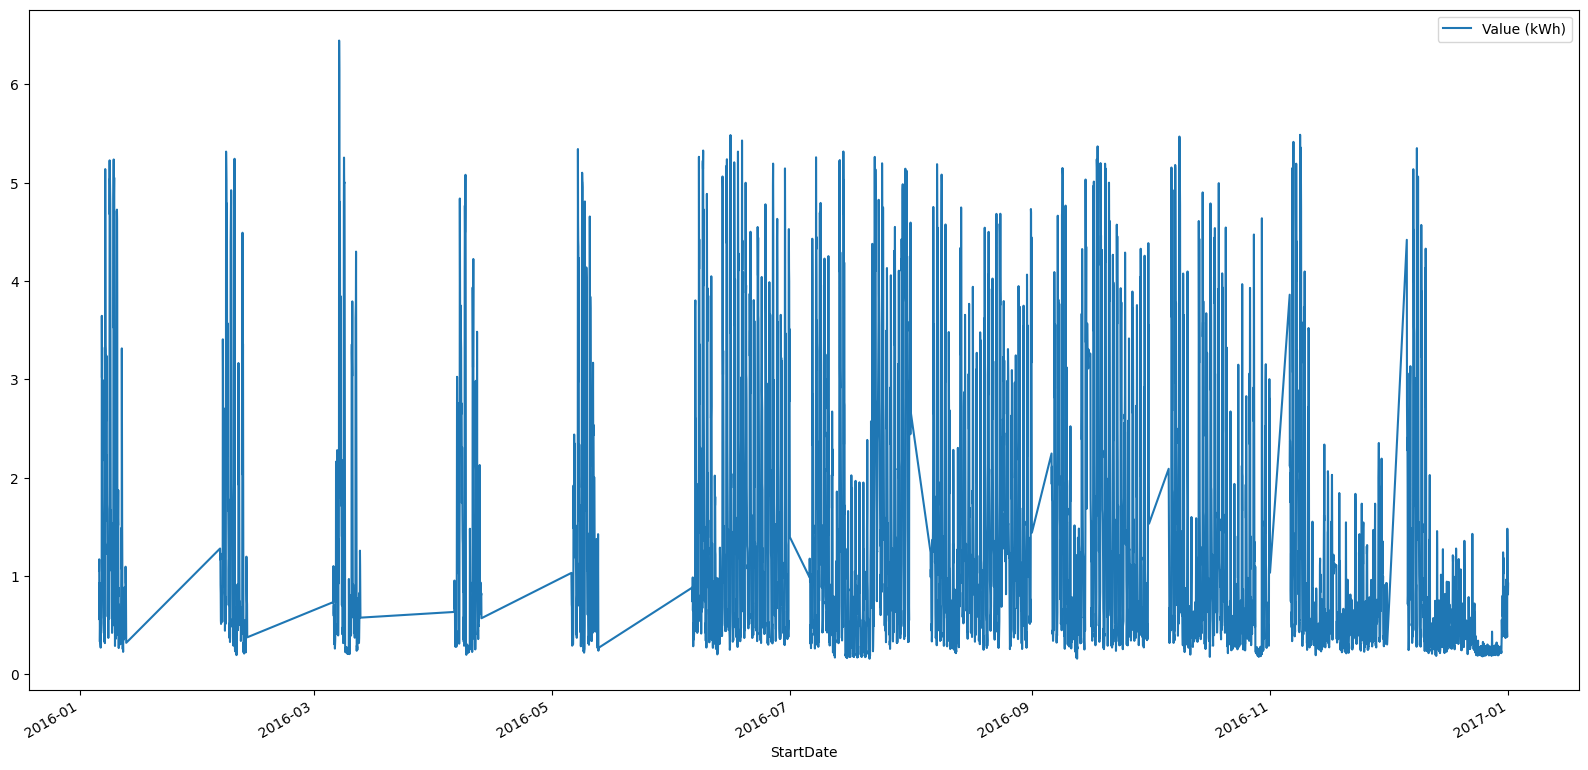

In [47]:
df2016 = sorteddf[sorteddf['year'] == 2016]
df2016.plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10))

In [48]:
df2016.groupby('month').agg('count')

,StartDate,Value (kWh),day_of_week,notes,year
month,,,,,
1,168,168,168,168,168
2,168,168,168,168,168
3,168,168,168,168,168
4,168,168,168,168,168
5,168,168,168,168,168
6,600,600,600,600,600
7,624,624,624,624,624
8,624,624,624,624,624
9,600,600,600,600,600


<Axes: xlabel='StartDate'>

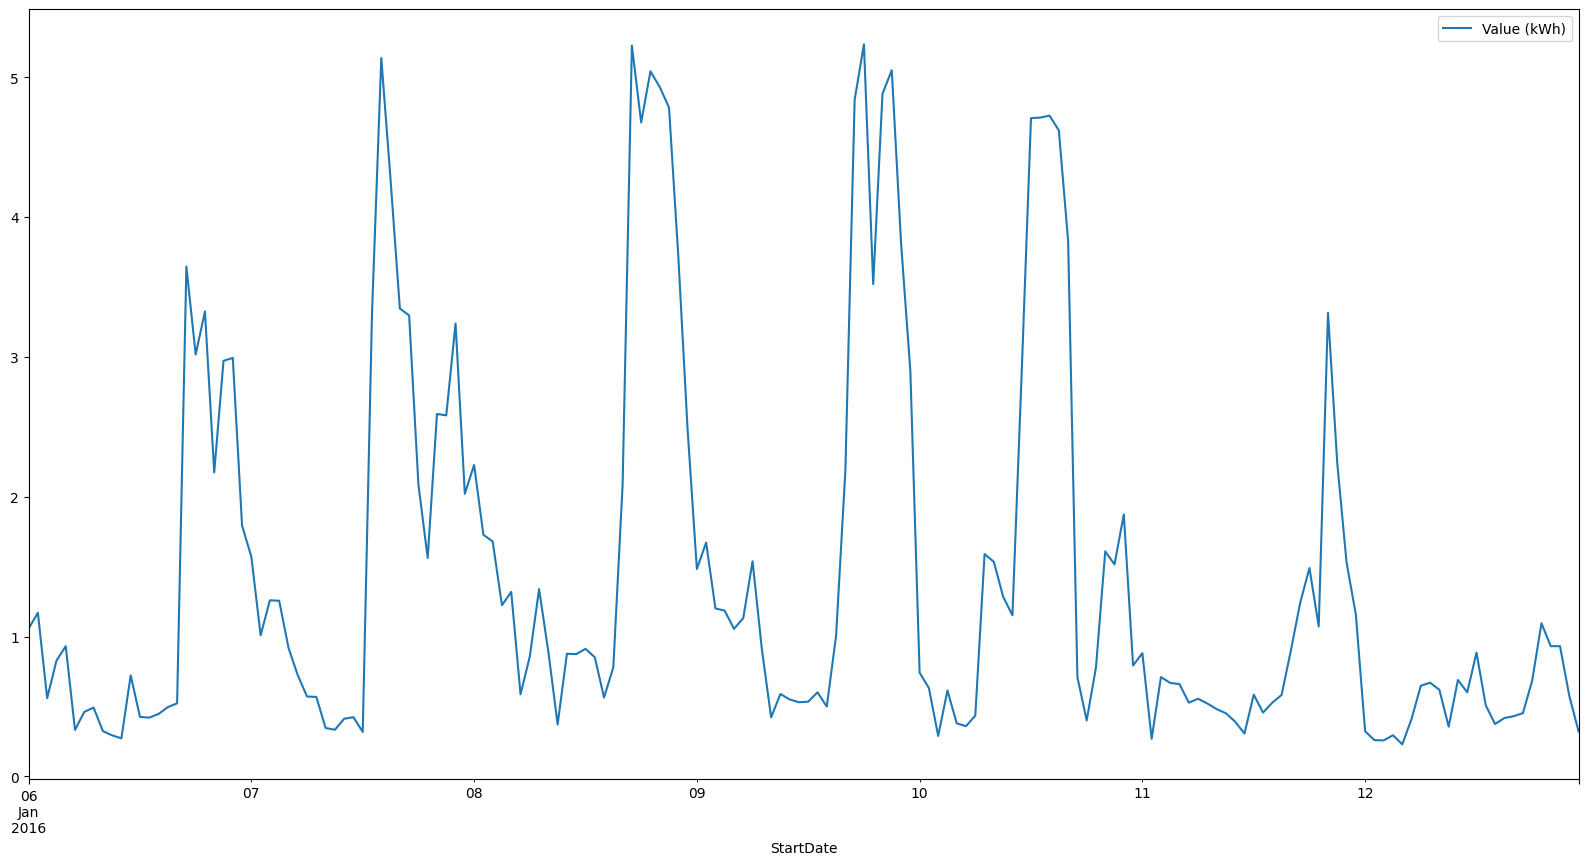

In [49]:
df2016[df2016['month']==1].plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10))

### 2016 appears to be missing days in the first 6 months and do not have full months for the remainder of the year. This would appear to be the case for end of 2020. A forecast will be generated for 2020 based on 2017 - 2019 and an anamoly detection for 2017 - 2019 will also be created.

## Forecast

In [50]:
df2 = sorteddf[sorteddf['year'].isin([2017, 2018, 2019])]
df2 = df2.sort_values(by='StartDate',ascending=True)

In [51]:
df2.groupby('year').agg('count')

,StartDate,Value (kWh),day_of_week,notes,month
year,,,,,
2017,8760,8760,8760,8760,8760
2018,8760,8760,8760,8760,8760
2019,8760,8760,8760,8760,8760


In [52]:
df2.head()

,StartDate,Value (kWh),day_of_week,notes,year,month
5136,2017-01-01 00:00:00,0.840,6,weekend,2017,1
5137,2017-01-01 01:00:00,0.731,6,weekend,2017,1
5138,2017-01-01 02:00:00,0.254,6,weekend,2017,1
5139,2017-01-01 03:00:00,0.270,6,weekend,2017,1
5140,2017-01-01 04:00:00,0.318,6,weekend,2017,1


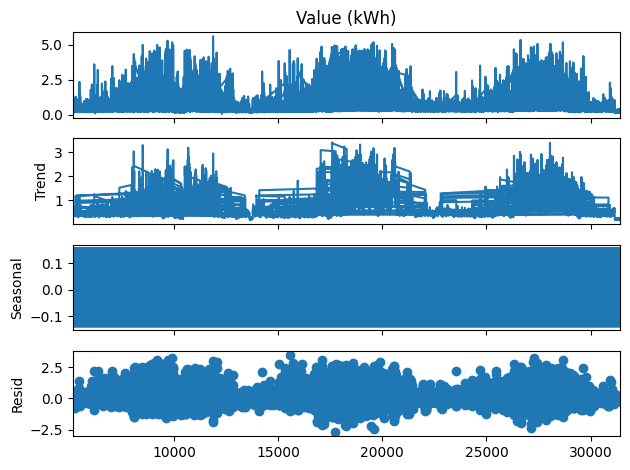

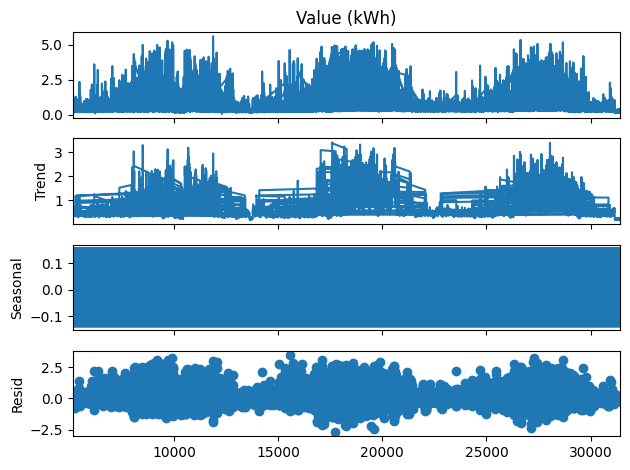

In [53]:
seasonal_decompose(df2['Value (kWh)'], model='additive', period=12).plot()

<Axes: xlabel='Date', ylabel='Value (kWh)'>

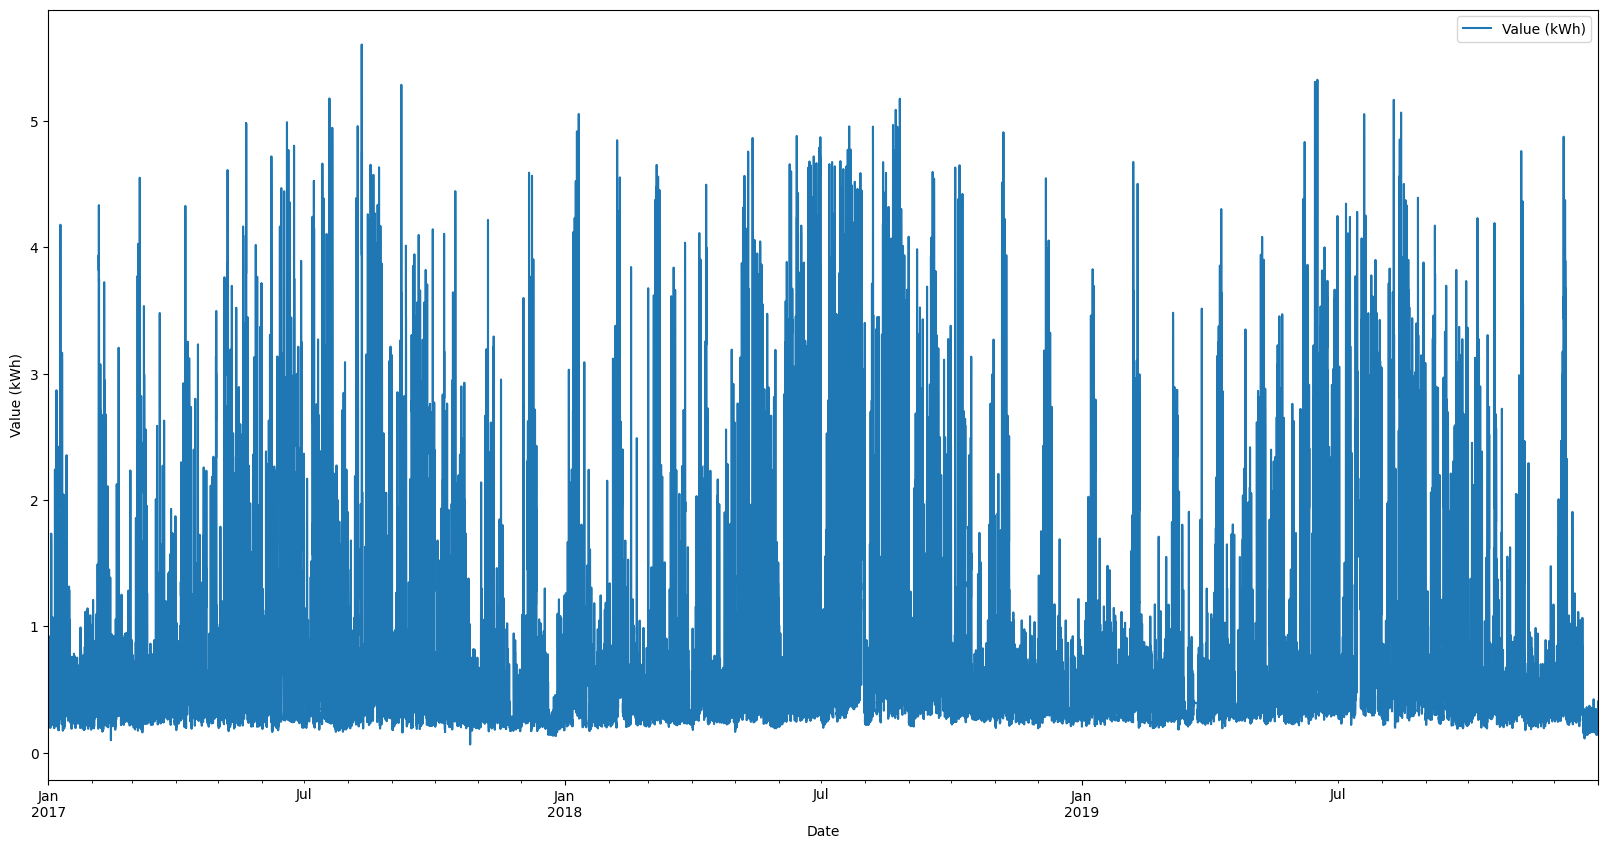

In [54]:
df2.plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10), xlabel='Date', ylabel='Value (kWh)')

<Axes: xlabel='Date', ylabel='Value (kWh)'>

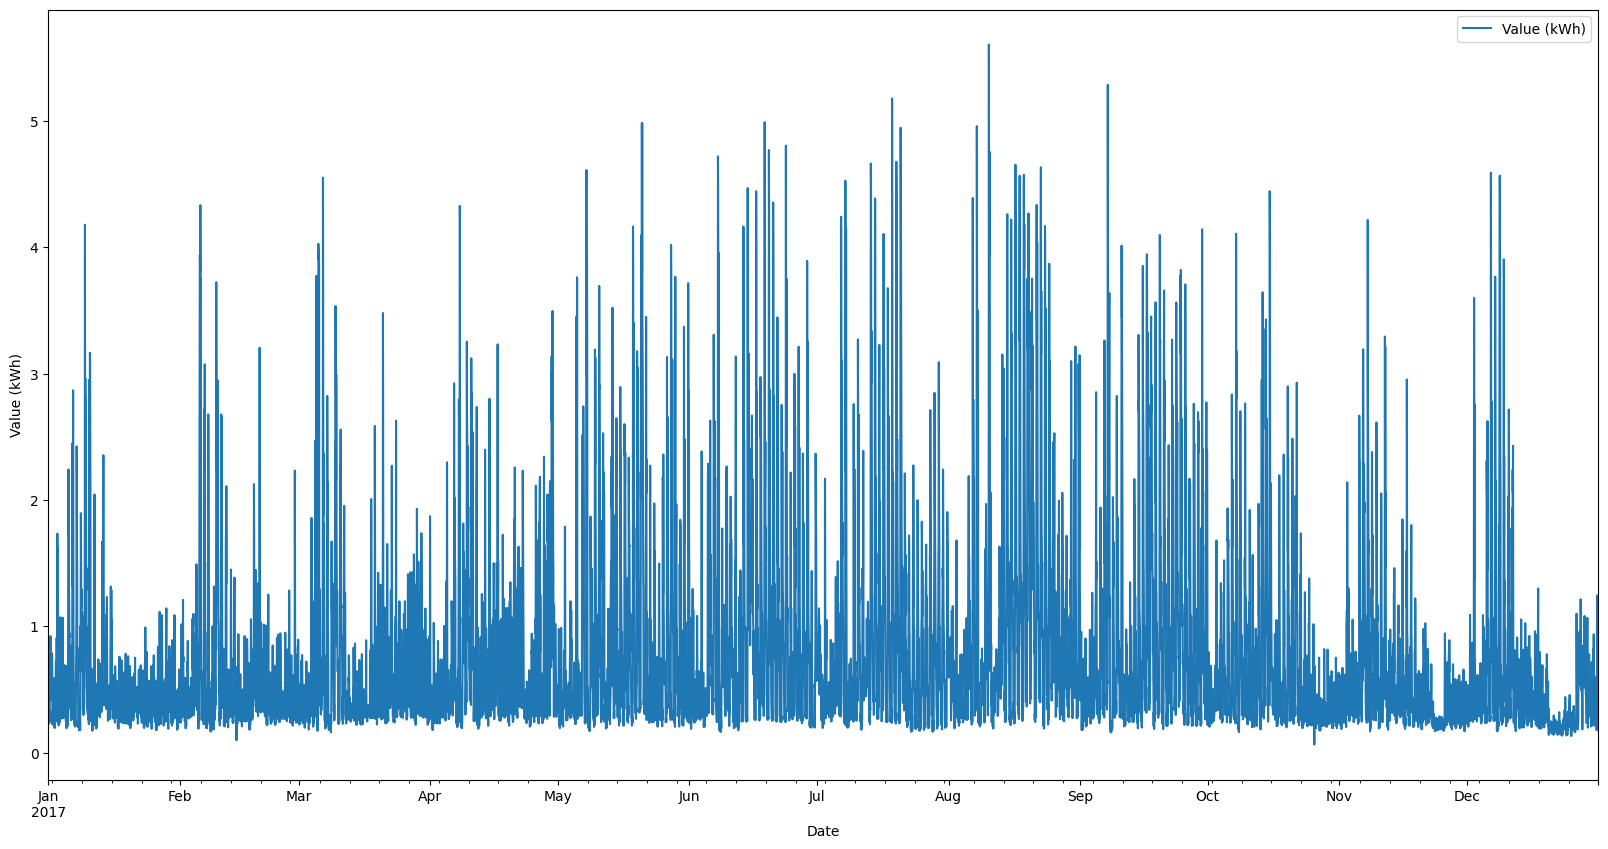

In [55]:
df2[df2['year']==2017].plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10), xlabel='Date', ylabel='Value (kWh)')

<Axes: xlabel='Date', ylabel='Value (kWh)'>

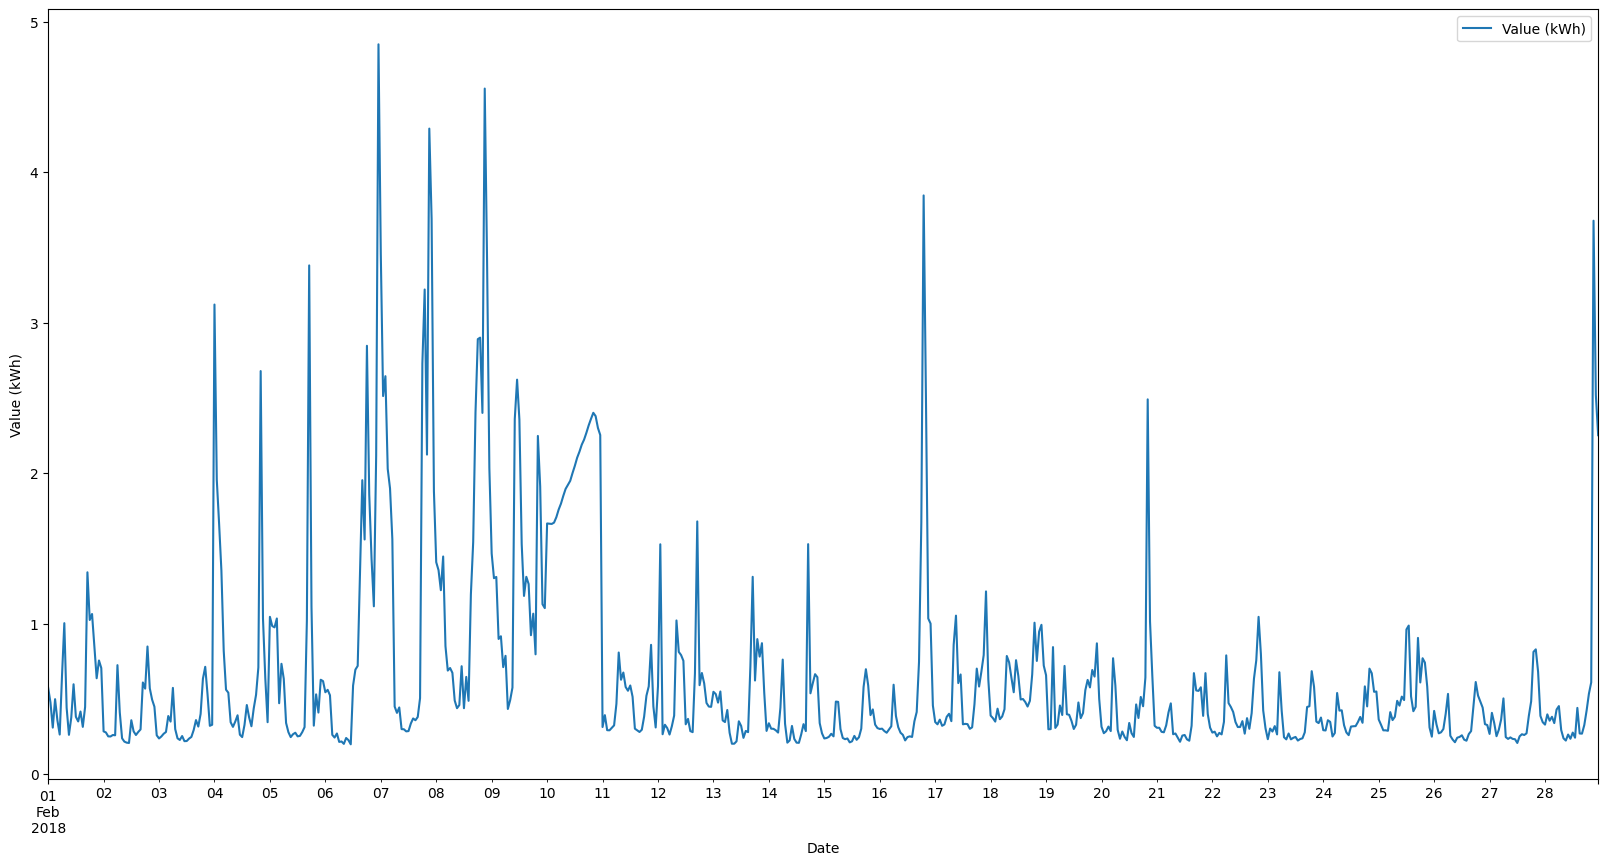

In [56]:
df2[(df2['year']==2018) & (df2['month']==2)].plot.line(x='StartDate', y='Value (kWh)', figsize=(20, 10), xlabel='Date', ylabel='Value (kWh)')

In [57]:
from statsmodels.tsa.stattools import adfuller

In [58]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(df2['Value (kWh)'])

Results of Dickey-Fuller Test:
Test Statistic                -1.107772e+01
p-value                        4.389651e-20
#Lags Used                     4.900000e+01
Number of Observations Used    2.623000e+04
Critical Value (1%)           -3.430599e+00
Critical Value (5%)           -2.861650e+00
Critical Value (10%)          -2.566829e+00
dtype: float64


In [59]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(df2['Value (kWh)'], regression='c', nlags="auto")

/var/folders/1s/_3xxr92n2m546tpmlwp5bssc0000gn/T/ipykernel_40915/1322946064.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df2['Value (kWh)'], regression='c', nlags="auto")


In [60]:
kpss_result

(0.7413425459779974,
 0.01,
 68,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Analysis from the ADF test shows the data is stationary while the KPSS test shows the data to be non-stationary at 5% significance. Use of differencing will be used to further analyze the data.

/var/folders/1s/_3xxr92n2m546tpmlwp5bssc0000gn/T/ipykernel_40915/3810252265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Value (kWh) Diff'] = df2['Value (kWh)'] - df2['Value (kWh)'].shift(5)


<Axes: xlabel='StartDate'>

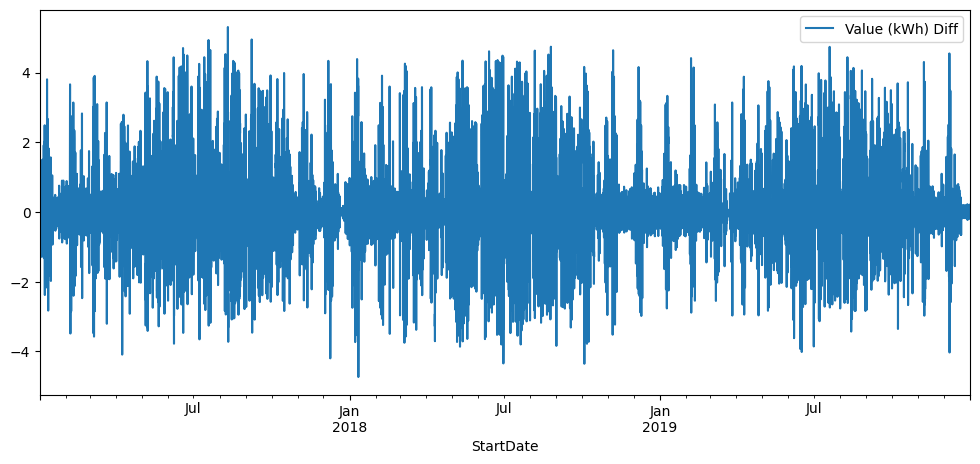

In [81]:
df2['Value (kWh) Diff'] = df2['Value (kWh)'] - df2['Value (kWh)'].shift(5)
#df2['Value (kWh) Diff'] = boxcox(df2['Value (kWh) Diff'], lmbda=0)
df2.dropna().plot(y='Value (kWh) Diff',x='StartDate',figsize=(12, 5))


In [82]:
adf_test(df2['Value (kWh) Diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -31.661245
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    26218.000000
Critical Value (1%)               -3.430599
Critical Value (5%)               -2.861650
Critical Value (10%)              -2.566829
dtype: float64


In [83]:
kpss_result2 = kpss(df2['Value (kWh) Diff'].dropna(), regression='c', nlags="auto")
kpss_result2

/var/folders/1s/_3xxr92n2m546tpmlwp5bssc0000gn/T/ipykernel_40915/2798207674.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result2 = kpss(df2['Value (kWh) Diff'].dropna(), regression='c', nlags="auto")


(0.00416297181167744,
 0.1,
 137,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

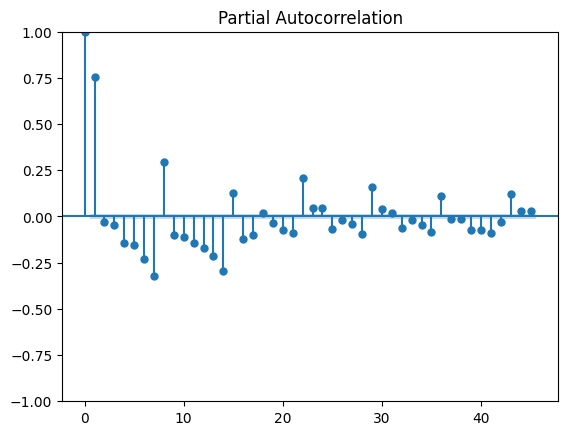

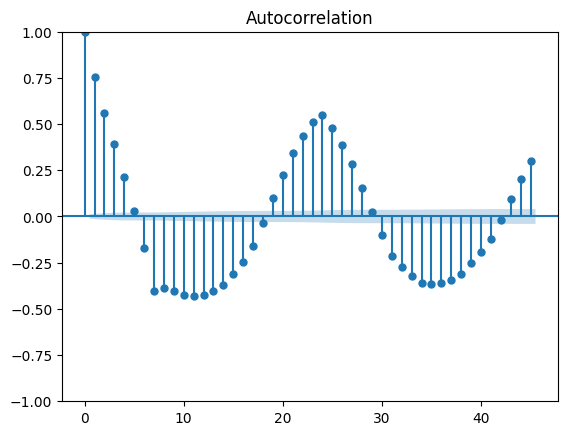

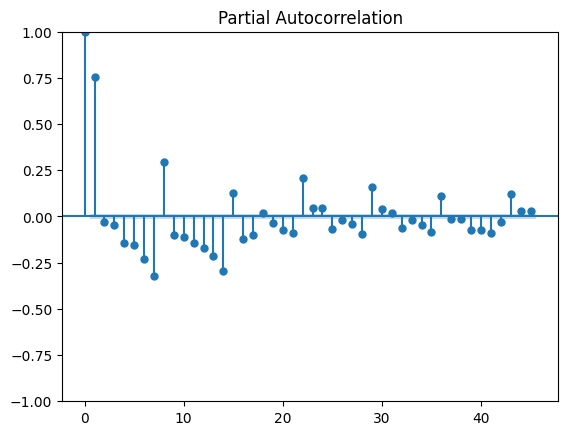

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df2['Value (kWh) Diff'].dropna())
plot_pacf(df2['Value (kWh) Diff'].dropna(),method='ywm')

### After differencing, the tests now show the data is stationary and will therefore be analzyed further as stationary data. An ARIMA model will be used to look into the forecasting the data.

In [69]:
df2 = df2.dropna()

In [72]:
ARIMA_model = ARIMA(df2['Value (kWh)'], order=(5, 1, 5))

In [73]:
ARIMA_model_fit = ARIMA_model.fit()

/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [74]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Value (kWh)   No. Observations:                26273
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -18850.940
Date:                Mon, 03 Feb 2025   AIC                          37723.880
Time:                        18:49:28   BIC                          37813.819
Sample:                             0   HQIC                         37752.921
                              - 26273                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7867      1.397     -0.563      0.573      -3.524       1.951
ar.L2         -0.3997      0.142     -2.820      0.005      -0.678      -0.122
ar.L3         -0.3227      0.455     -0.710      0.478      -1.214       0.569
ar.L4          0.5668      0.154      3.672      0.000       0.264       0.869
ar.L5          0.4534      0.905      0.501      0.616      -1.320       2.227
ma.L1          0.5579      1.397      0.399      0.690      -2.181       3.297
ma.L2          0.0321      0.185      0.174      0.862      -0.330       0.394
ma.L3         -0.0322      0.163     -0.198      0.843      -0.351       0.286
ma.L4         -0.9038      0.145     -6.215      0.000      -1.189      -0.619
ma.L5         -0.5863      1.177     -0.498      0.618      -2.893       1.721
sigma2         0.2484      0.001    295.698      0.000       0.247       0.250
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):            209643.54
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             2.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

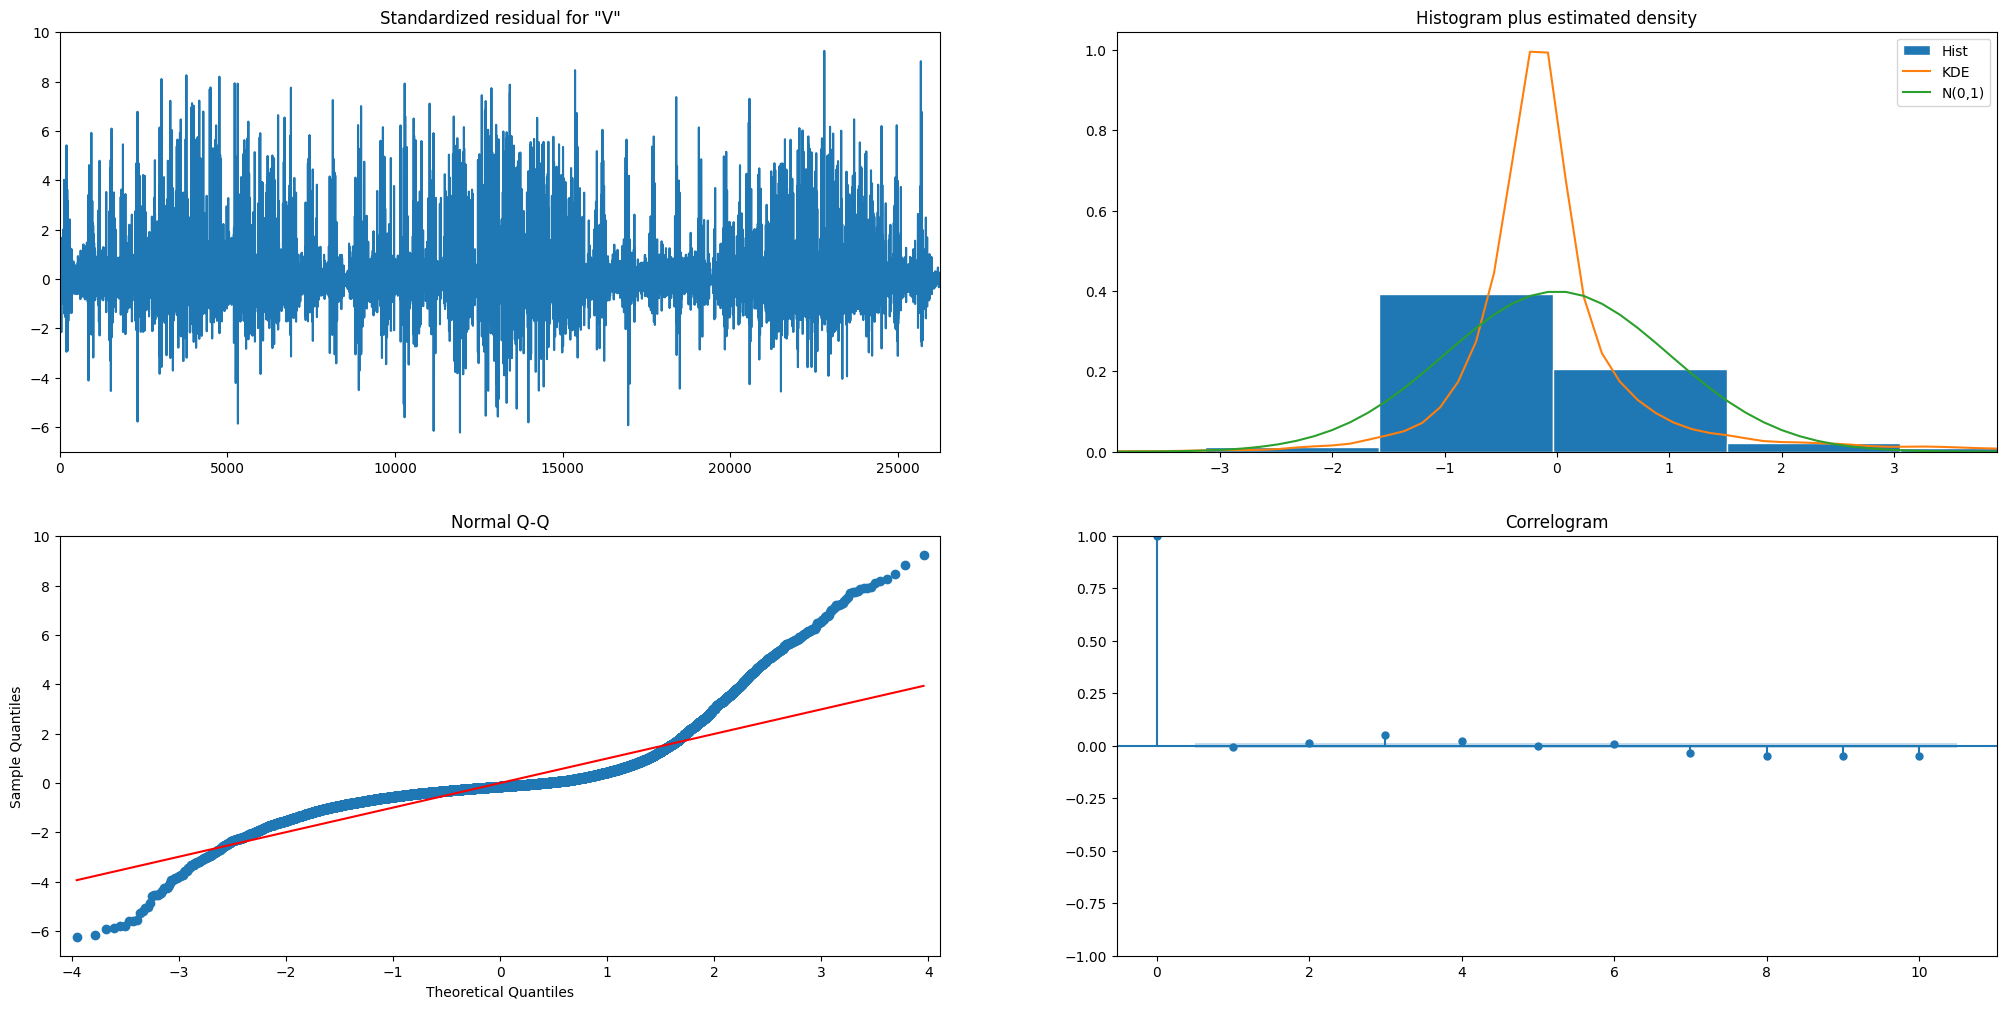

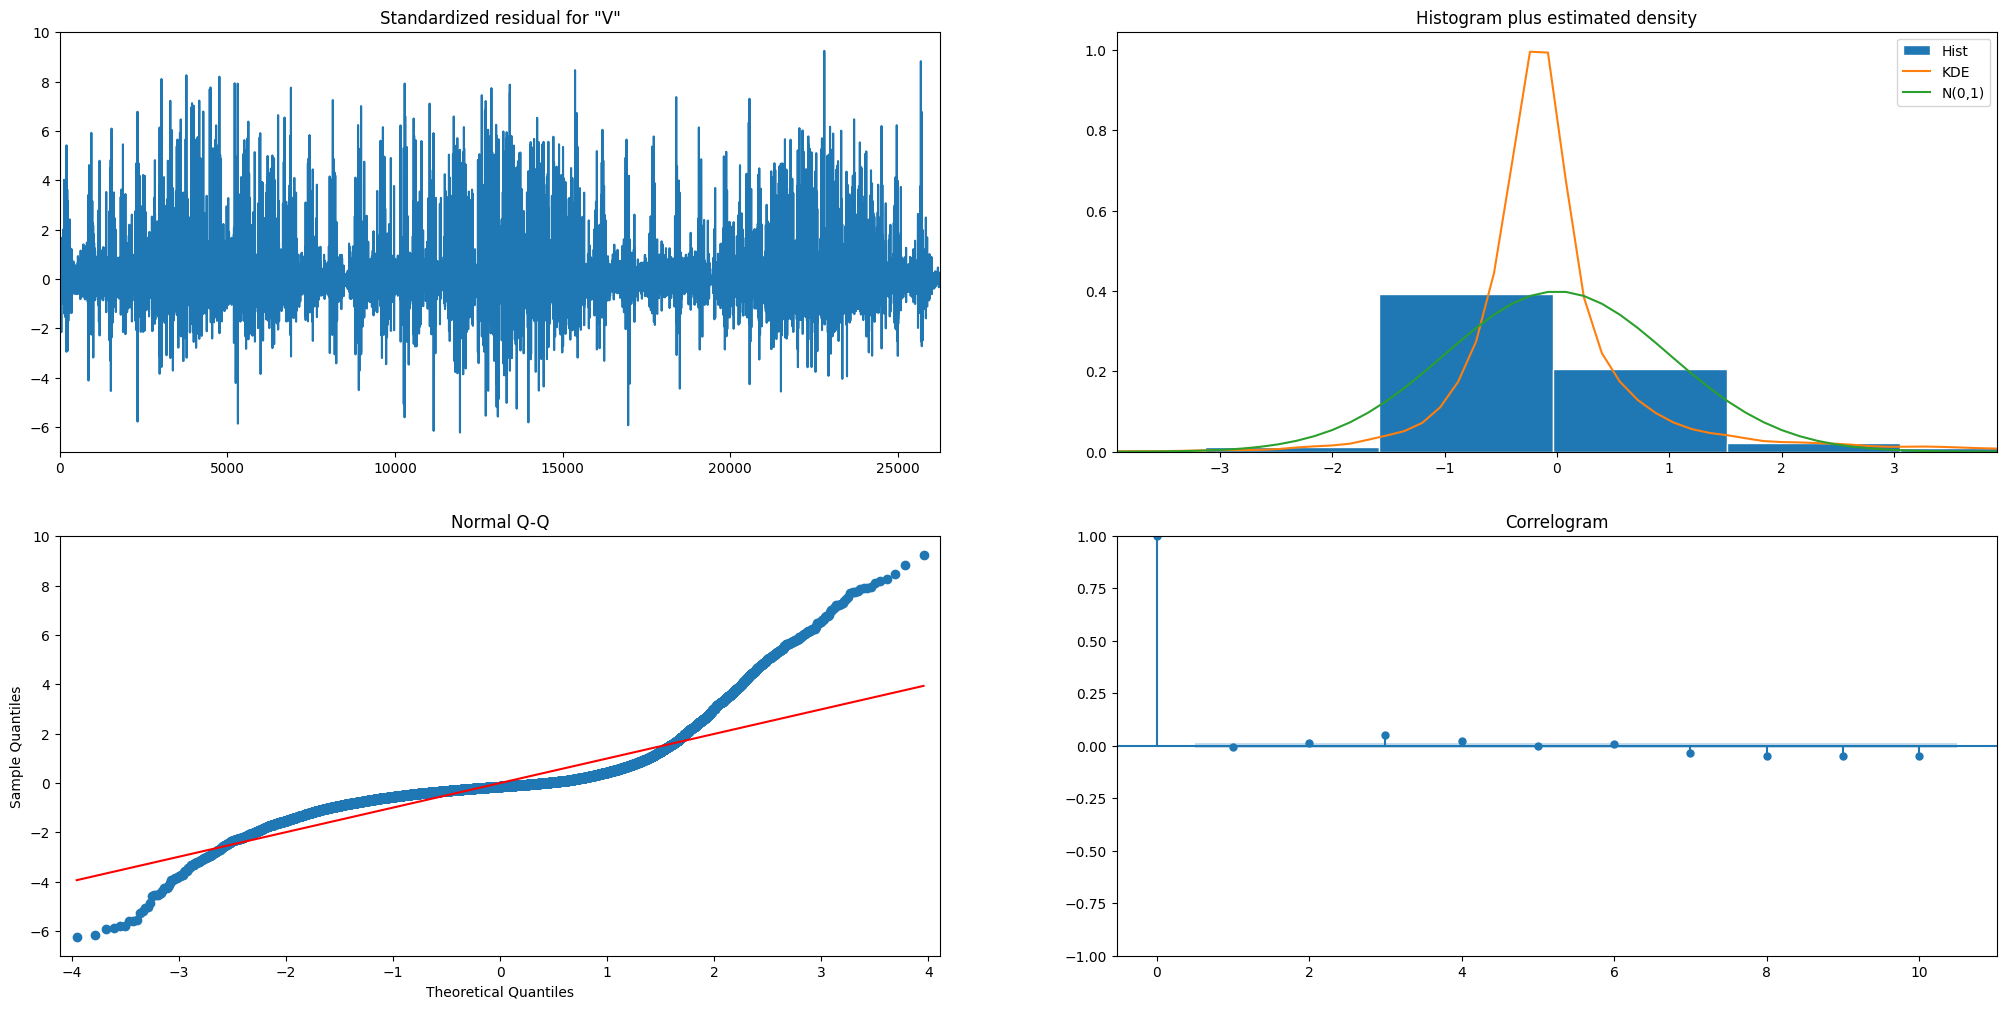

In [75]:
ARIMA_model_fit.plot_diagnostics(figsize=(25, 12))

In [76]:
pred = ARIMA_model_fit.forecast(steps=300)

/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/ed/Documents/Machine Learning/Python Analysis/OtherML/ml1/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


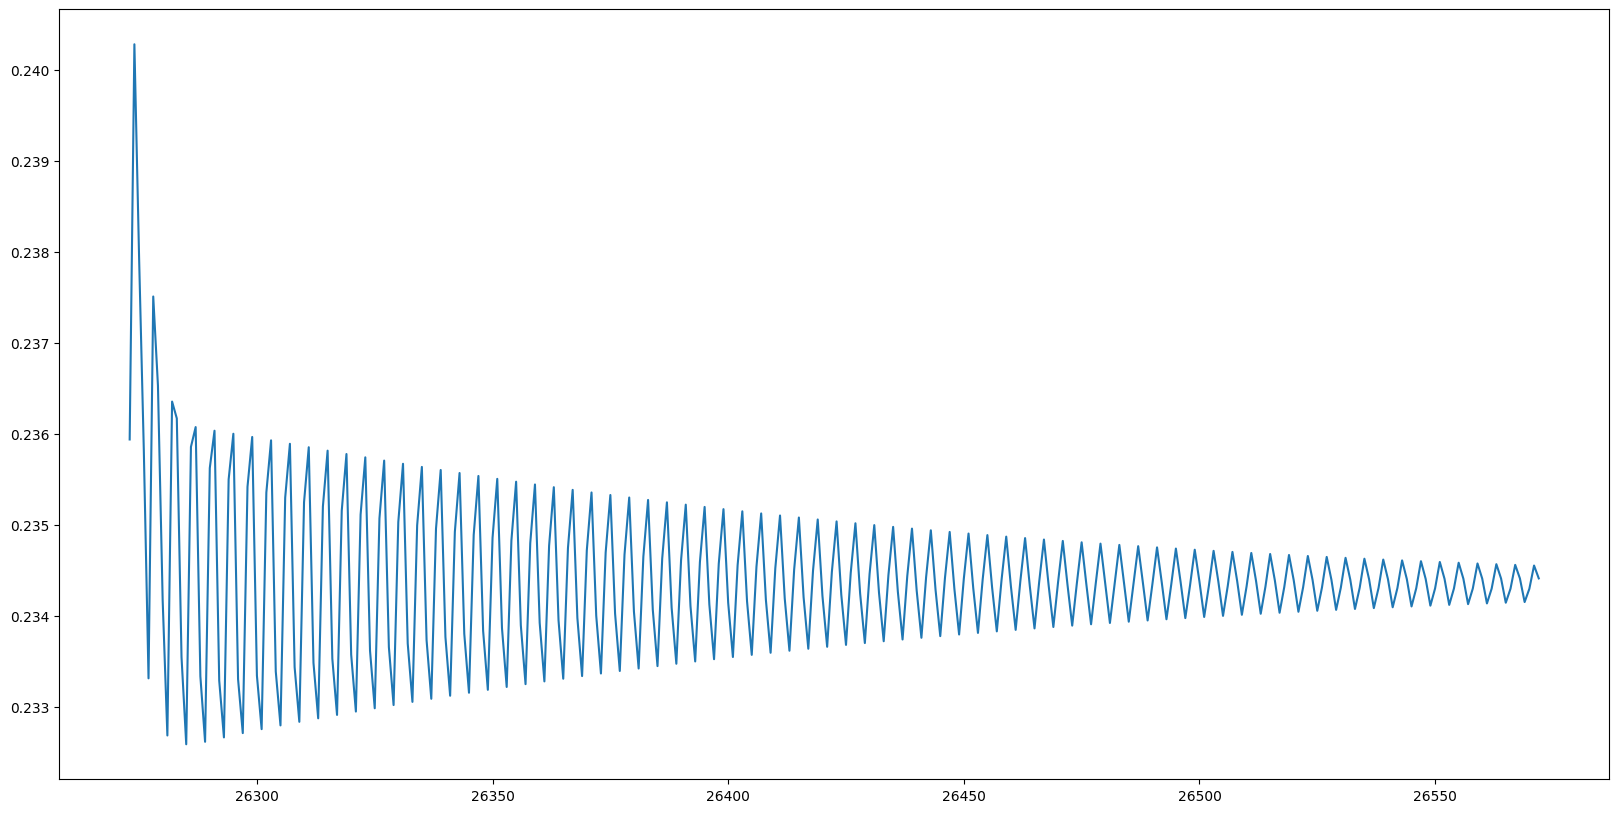

In [77]:
plt.figure(figsize=(20, 10))
plt.plot(pred)
